<a href="https://colab.research.google.com/github/ToniMarGar/Final_Project-Clothify/blob/main/Proyecto_final_InceptionV3_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import zipfile
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle

In [ ]:
'''
# ==============================
# Paso 1: Descomprimir archivo zip
# ==============================
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Descomprimir (Ajustar rutas según sea necesario)
zip_path = "path_to_your_zip_file.zip"  # Ruta al archivo zip
extract_to = "extracted_images"        # Carpeta de destino
unzip_file(zip_path, extract_to)
'''

In [6]:
# ==============================
# Paso 2: Preprocesar imágenes
# ==============================
def preprocess_images(data_dir, batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0 / 255)  # Solo reescalar las imágenes
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical',  # Usar 'categorical' para clasificación
        shuffle=True
    )
    return generator

# Configuración del generador de datos
data_dir = "/content/dataset__aumentado"  # Carpeta con imágenes descomprimidas
generator = preprocess_images(data_dir)

Found 32798 images belonging to 23 classes.


In [7]:
# ==============================
# Paso 3: Cargar modelo preentrenado y hacer fine-tuning
# ==============================
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(generator.class_indices), activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Congelar capas base para fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ajustar el modelo
model.fit(generator, epochs=20, verbose=1)  # Usar el objeto 'generator'

modified_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Guarda el modelo modificado
modified_model.save('/content/Definitive_model.keras')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   5/1025 ━━━━━━━━━━━━━━━━━━━━ 2:42:21 10s/step - accuracy: 0.0247 - loss: 3.5656

KeyboardInterrupt: 

In [ ]:
# ==============================
# Paso 4: Extraer embeddings
# ==============================
embedding_model = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)

def extract_embeddings_from_folder(folder_path, model):
    embeddings = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('jpg', 'jpeg', 'png')):
            img_path = os.path.join(folder_path, filename)
            embedding = extract_embedding(img_path, model)
            embeddings[filename] = embedding
    return embeddings

def extract_embedding(img_path, model):
    img = Image.open(img_path).resize((299, 299))
    img_array = np.array(img) / 255.0  # Normalizar la imagen
    img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión batch
    embedding = model.predict(img_array)
    return embedding.flatten()

# Extraer embeddings de la base de datos
database_embeddings = extract_embeddings_from_folder(data_dir, embedding_model)

# Exportar los embeddings
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(database_embeddings, f)

In [ ]:


# ==============================
# Paso 5: Comparar y mostrar las 3 imágenes más similares
# ==============================
def find_top_k_similar(query_embedding, database_embeddings, k=3):
    similarities = []
    for filename, embedding in database_embeddings.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((filename, similarity))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:k]

# Función para cargar una imagen desde una URL
def extract_embedding_from_url(image_url, model):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize((299, 299))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    embedding = model.predict(img_array)
    return embedding.flatten()

# URL de prueba
query_image_url = "https://www.soloepis.com/7990-large_default/camiseta-algodn-varios-colores.jpg"
query_embedding = extract_embedding_from_url(query_image_url, embedding_model)

# Buscar las 3 más similares
top_k_matches = find_top_k_similar(query_embedding, database_embeddings, k=3)

# Mostrar imágenes al usuario
def display_results(query_url, top_k_matches, data_dir):
    fig, axes = plt.subplots(1, len(top_k_matches) + 1, figsize=(15, 5))

    # Mostrar imagen de consulta
    response = requests.get(query_url)
    img = Image.open(BytesIO(response.content))
    axes[0].imshow(img)
    axes[0].set_title("Imagen de consulta")
    axes[0].axis('off')

    # Mostrar imágenes similares
    for i, (filename, similarity) in enumerate(top_k_matches):
        img_path = os.path.join(data_dir, filename)
        similar_img = Image.open(img_path)
        axes[i + 1].imshow(similar_img)
        axes[i + 1].set_title(f"Similaridad: {similarity:.2f}")
        axes[i + 1].axis('off')

    plt.show()

# Mostrar resultados
display_results(query_image_url, top_k_matches, data_dir)


1. Descomprimir el archivo ZIP

In [4]:
import zipfile

archivo_zip = '/content/minii_dataset.zip'
archivo_zip2 = '/content/dataset__aumentado.zip'
carpeta_destino = '/content'

with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)
with zipfile.ZipFile(archivo_zip2, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)

2. Preprocesar las imágenes y preparar el dataset

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

dataset_path = "/content/dataset"
target_size = (299, 299)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    subset='training',
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)


Found 26243 images belonging to 23 classes.
Found 6555 images belonging to 23 classes.



3. Cargar el modelo preentrenado y hacer Fine-Tuning

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
prenda_output = Dense(train_generator.num_classes, activation='softmax', name='prenda_output')(x)

model = Model(inputs=base_model.input, outputs=prenda_output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=20)

model.save('/content/modelo_finito.h5')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


821/821 ━━━━━━━━━━━━━━━━━━━━ 171s 181ms/step - accuracy: 0.4662 - loss: 1.6472 - val_accuracy: 0.5252 - val_loss: 1.4069
Epoch 2/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 126s 152ms/step - accuracy: 0.6899 - loss: 0.9052 - val_accuracy: 0.5396 - val_loss: 1.5008
Epoch 3/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 127s 154ms/step - accuracy: 0.7381 - loss: 0.7433 - val_accuracy: 0.5483 - val_loss: 1.5375
Epoch 4/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 141s 153ms/step - accuracy: 0.7743 - loss: 0.6448 - val_accuracy: 0.5324 - val_loss: 1.5997
Epoch 5/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 128s 155ms/step - accuracy: 0.8129 - loss: 0.5354 - val_accuracy: 0.5407 - val_loss: 1.6688
Epoch 6/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 141s 154ms/step - accuracy: 0.8327 - loss: 0.4801 - val_accuracy: 0.5533 - val_loss: 1.7437
Epoch 7/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 127s 153ms/step - accuracy: 0.8537 - loss: 0.4202 - val_accuracy: 0.5210 - val_loss: 1.8629
Epoch 8/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 148s 161ms/step - accuracy: 0.8654 - loss: 0.37

In [ ]:
from tensorflow.keras.models import Model
#-------------------------------------------revisar linea quitar ultima capa-------------------------------------------------
# Supongamos que tienes un modelo existente llamado `modelo`
# Verifica la estructura del modelo
modelo.summary()

# Crea un nuevo modelo excluyendo la última capa
modelo_modificado = Model(inputs=modelo.input, outputs=modelo.layers[-2].output)

# Verifica la nueva estructura
modelo_modificado.summary()

# Guarda el modelo modificado
modelo_modificado.save('ruta_a_guardar_modelo_modificado.h5')


In [2]:
from tensorflow.keras.models import load_model
from keras.models import Model

model = load_model('/content/Inception_model.keras')

embedding_model = Model(inputs=model.input,
                          outputs=model.get_layer('dense').output)

4. Extraer embeddings para las prendas

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def generate_embeddings(folder_path, model):
    embeddings = []
    image_names = []
    for root, _, files in os.walk(folder_path):
        for img_file in files:
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, img_file)
                img = image.load_img(img_path, target_size=(299, 299))
                img_array = image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                embedding = model.predict(img_array)
                embeddings.append(embedding.flatten())
                relative_path = os.path.relpath(img_path, folder_path)
                image_names.append(relative_path)
    return np.array(embeddings), image_names

dataset_path = "/content/minii_dataset"

embeddings, image_names = generate_embeddings(dataset_path, embedding_model)
embeddings_dict = {name: embedding for name, embedding in zip(image_names, embeddings)}

output_path = "embeddings.npz"
np.savez(output_path, embeddings=embeddings, image_names=image_names)

print(f"Embeddings exportados exitosamente a {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
import numpy as np

output_path = "/content/embeddings.npz"
np.savez(output_path, embeddings=embeddings, image_names=image_names)

print(f"Embeddings exportados exitosamente a {output_path}")


Embeddings exportados exitosamente a /content/embeddings.npz


5. Encontrar prendas similares a la imagen del usuario

In [8]:
import os
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        return img
    else:
        raise ValueError(f"Error al descargar la imagen desde la URL: {response.status_code}")

def find_top_similar(query_embedding, embeddings_dict, top_n=3):
    similarities = []
    for filename, embedding in embeddings_dict.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((filename, similarity))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

query_image_url = 'https://meuaboutique.com/wp-content/uploads/2023/10/Vestido-fiesta-largo-plisado-con-abertura-Sensy-AZULON-scaled.jpg'  # Cambia esta URL por la de tu imagen
query_image = load_image_from_url(query_image_url)

query_image_processed = query_image.resize((224, 224))

query_image_path = '/tmp/query_image.jpg'
query_image_processed.save(query_image_path)

query_embedding, _ = generate_embeddings(os.path.dirname(query_image_path), embedding_model)

top_similar_images = find_top_similar(query_embedding[0], embeddings_dict, top_n=3)
print(f"Prendas similares: {top_similar_images}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Prendas similares: [('Dresses_W/id_00000074.jpg', 0.6842357), ('Dresses_W/id_00000021.jpg', 0.6832807), ('Skirts_W/id_00000595.jpg', 0.6772754)]


In [26]:
import os
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

def load_image_from_path(image_path):
    if os.path.exists(image_path):
        img = Image.open(image_path)
        return img
    else:
        raise FileNotFoundError(f"La imagen no se encontró en la ruta especificada: {image_path}")

def find_top_similar(query_embedding, embeddings_dict, top_n=3):
    similarities = []
    for filename, embedding in embeddings_dict.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((filename, similarity))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

query_image_path = '/content/minii_dataset/Denim_W/id_00000162.jpg'

query_image = load_image_from_path(query_image_path)

query_image_processed = query_image.resize((224, 224))

query_image_temp_path = '/tmp/query_image.jpg'
query_image_processed.save(query_image_temp_path)

query_embedding, _ = generate_embeddings(os.path.dirname(query_image_temp_path), embedding_model)

top_similar_images = find_top_similar(query_embedding[0], embeddings_dict, top_n=5)
print(f"Prendas similares: {top_similar_images}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
Prendas similares: [('Denim_W/id_00000162.jpg', 0.92246664), ('Leggings_W/id_00001032.jpg', 0.7724426), ('Pants_W/id_00000315.jpg', 0.72035354), ('Rompers_Jumpsuits_W/id_00000554.jpg', 0.6819794), ('Denim_W/id_00000624.jpg', 0.6762842)]


7. Mostrar imágenes al usuario

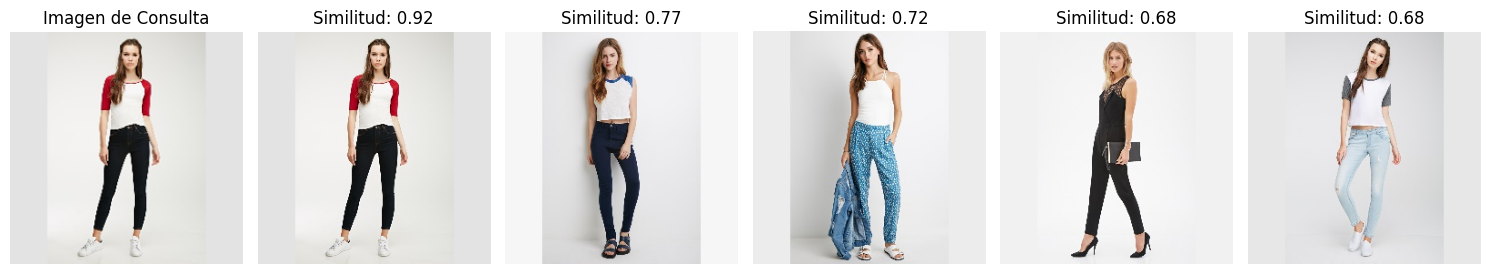

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images(query_image, similar_images, dataset_path):
    fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(15, 5))

    if isinstance(query_image, Image.Image):
        axes[0].imshow(query_image)
    else:
        axes[0].imshow(Image.open(query_image))
    axes[0].axis('off')
    axes[0].set_title("Imagen de Consulta")

    for i, (filename, similarity) in enumerate(similar_images):
        img_path = os.path.join(dataset_path, filename)
        axes[i + 1].imshow(Image.open(img_path))
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"Similitud: {similarity:.2f}")

    plt.tight_layout()
    plt.show()

show_images(query_image_processed, top_similar_images, dataset_path)


In [ ]:
print(embeddings.shape)

(112, 1024)
